# Visualize PCA of weight, activity and Estimates MI from data

## Import lib

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader , TensorDataset
from torchvision.utils import save_image, make_grid
from torch.optim import Adam
import torch.nn.init as init

import numpy as np
import math

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import MultipleLocator
import matplotlib.cm as cm

import copy
import seaborn as sns

from scipy.stats import norm
from sklearn.neighbors import KernelDensity, LocalOutlierFactor
from sklearn.decomposition import PCA

import tqdm

import pickle

# MI estimators
from utils.estimators import *

## Load data

In [284]:
with open("data/weight_dynamic/HEBB-FULL_STATE-seed_0-rand-0.pkl", "rb") as f:
    loaded_buffer = pickle.load(f)
with open("data/weight_dynamic/ZERO-HEBB-FULL_STATE-seed_0-rand-0.pkl", "rb") as m:
    loaded_zero = pickle.load(m)
with open("data/weight_dynamic/ZERO_LONG-HEBB-FULL_STATE-seed_0-rand-0.pkl", "rb") as m:
    loaded_zero_long = pickle.load(m)
with open("data/weight_dynamic/ZERO_LONG2-HEBB-FULL_STATE-seed_0-rand-0.pkl", "rb") as m:
    loaded_zero_long2 = pickle.load(m)

In [3]:
def reshape_to_single(val):
    '''
    Input dim : [timestep , np:[1,dim] ]
    Return dim : np: [timestep , dim]
    '''
    for i in range(len(val)):
        val[i] = val[i].reshape(-1)
    return np.array(val)

In [4]:
def select_activity_layer(activity,selected_layer):
    '''
    Input dim : [timestep][layer]
    Return dim : np: [timestep , dim]
    '''
    buff = []
    for t in range(len(activity)):
        layer = activity[t][selected_layer]
        buff.append(layer.reshape(-1) if isinstance(layer, np.ndarray) else layer.numpy().reshape(-1))
    return np.array(buff , dtype=object)

In [5]:
def select_weight_layer(weight,selected_layer):
    '''
    Input dim : [timestep][layer]
    Return dim : np: [timestep , dim]
    '''
    buff = []
    for t in range(len(weight)):
        _b = weight[t][selected_layer][0]
        buff.append(_b if isinstance(_b, np.ndarray) else _b.numpy())
    return np.array(buff , dtype=object)

Load Normal

In [59]:
normal = {}
load = loaded_buffer
activity    = load["brain"]["activity"]              # [timestep][layer_n][ 1 , hidden_dim]
weight      = load["brain"]["weight"]                # [timestep][layer_n][ 1 , 64 , 128]
normal["input"]       = reshape_to_single(load["data"]["state"])           # [timestep][1 , all_observation] ---reshape---> [timestep, all_obs]
normal["act_hid_1"]   = select_activity_layer(activity , 0)             # [timestep][layer_n][1 , hidden_dim] ---reshape---> [timestep, num_dim_of_selected_layer]
normal["act_hid_2"]   = select_activity_layer(activity , 1)
normal["weight_hid_1"] = select_weight_layer(weight,0)
normal["weight_hid_2"] = select_weight_layer(weight,1)
normal["weight_hid_3"] = select_weight_layer(weight,2)
normal["output"]      = reshape_to_single(load["data"]["action"])          # [timestep][1 , all_observation] ---reshape---> [timestep, all_obs]

Load Morph

In [60]:
zero = {}
load = loaded_zero
activity    = load["brain"]["activity"]              # [timestep][layer_n][ 1 , hidden_dim]
weight      = load["brain"]["weight"]                # [timestep][layer_n][ 1 , 64 , 128]
zero["input"]       = reshape_to_single(load["data"]["state"])           # [timestep][1 , all_observation] ---reshape---> [timestep, all_obs]
zero["act_hid_1"]   = select_activity_layer(activity , 0)             # [timestep][layer_n][1 , hidden_dim] ---reshape---> [timestep, num_dim_of_selected_layer]
zero["act_hid_2"]   = select_activity_layer(activity , 1)
zero["weight_hid_1"] = select_weight_layer(weight,0)
zero["weight_hid_2"] = select_weight_layer(weight,1)
zero["weight_hid_3"] = select_weight_layer(weight,2)
zero["output"]      = reshape_to_single(load["data"]["action"])          # [timestep][1 , all_observation] ---reshape---> [timestep, all_obs]
zero["torque"]      = reshape_to_single(load["data"]["torque"])
zero["reward"]      = reshape_to_single(load["data"]["reward"])

In [64]:
zero_long = {}
load = loaded_zero_long
activity    = load["brain"]["activity"]              # [timestep][layer_n][ 1 , hidden_dim]
weight      = load["brain"]["weight"]                # [timestep][layer_n][ 1 , 64 , 128]
zero_long["input"]       = reshape_to_single(load["data"]["state"])           # [timestep][1 , all_observation] ---reshape---> [timestep, all_obs]
zero_long["act_hid_1"]   = select_activity_layer(activity , 0)             # [timestep][layer_n][1 , hidden_dim] ---reshape---> [timestep, num_dim_of_selected_layer]
zero_long["act_hid_2"]   = select_activity_layer(activity , 1)
zero_long["weight_hid_1"] = select_weight_layer(weight,0)
zero_long["weight_hid_2"] = select_weight_layer(weight,1)
zero_long["weight_hid_3"] = select_weight_layer(weight,2)
zero_long["output"]      = reshape_to_single(load["data"]["action"])          # [timestep][1 , all_observation] ---reshape---> [timestep, all_obs]
zero_long["torque"]      = reshape_to_single(load["data"]["torque"])
zero_long["reward"]      = reshape_to_single(load["data"]["reward"])

In [285]:
zero_long2 = {}
load = loaded_zero_long2
activity    = load["brain"]["activity"]              # [timestep][layer_n][ 1 , hidden_dim]
weight      = load["brain"]["weight"]                # [timestep][layer_n][ 1 , 64 , 128]
zero_long2["input"]       = reshape_to_single(load["data"]["state"])           # [timestep][1 , all_observation] ---reshape---> [timestep, all_obs]
zero_long2["act_hid_1"]   = select_activity_layer(activity , 0)             # [timestep][layer_n][1 , hidden_dim] ---reshape---> [timestep, num_dim_of_selected_layer]
zero_long2["act_hid_2"]   = select_activity_layer(activity , 1)
zero_long2["weight_hid_1"] = select_weight_layer(weight,0)
zero_long2["weight_hid_2"] = select_weight_layer(weight,1)
zero_long2["weight_hid_3"] = select_weight_layer(weight,2)
zero_long2["output"]      = reshape_to_single(load["data"]["action"])          # [timestep][1 , all_observation] ---reshape---> [timestep, all_obs]
zero_long2["torque"]      = reshape_to_single(load["data"]["torque"])
zero_long2["reward"]      = reshape_to_single(load["data"]["reward"])

## PCA of HIDDEN LAYER

In [9]:
def PCA_plot3D_single(pca):
    # Create a 3D scatter plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    # Plot the transformed data
    ax.scatter(pca[:, 0], pca[:, 1], pca[:, 2], label='w_hid1_flat', c='r', marker='o' ,s=10)
    # Labels and title
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')
    ax.set_zlabel('PCA Component 3')
    ax.set_title('PCA')
    # Show legend
    ax.legend()
    # Show plot
    plt.show()

In [10]:
def PCA_plot3D_three(pca1,pca2,pca3):
    # Create a figure with 3 subplots (1 row, 3 columns)
    fig = plt.figure(figsize=(15, 5))

    # First subplot (for w_hid1_flat)
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.scatter(pca1[:, 0], pca1[:, 1], pca1[:, 2], c='r', marker='o', s=10)
    ax1.set_xlabel('PCA Component 1')
    ax1.set_ylabel('PCA Component 2')
    ax1.set_zlabel('PCA Component 3')
    ax1.set_title('PCA data 1')

    # Second subplot (for w_hid2_flat)
    ax2 = fig.add_subplot(132, projection='3d')
    ax2.scatter(pca2[:, 0], pca2[:, 1], pca2[:, 2], c='g', marker='o', s=10)
    ax2.set_xlabel('PCA Component 1')
    ax2.set_ylabel('PCA Component 2')
    ax2.set_zlabel('PCA Component 3')
    ax2.set_title('PCA data 2')

    # Third subplot (for w_hid3_flat)
    ax3 = fig.add_subplot(133, projection='3d')
    ax3.scatter(pca3[:, 0], pca3[:, 1], pca3[:, 2], c='b', marker='o', s=10)
    ax3.set_xlabel('PCA Component 1')
    ax3.set_ylabel('PCA Component 2')
    ax3.set_zlabel('PCA Component 3')
    ax3.set_title('PCA data 3')

    # Show the plot
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

In [11]:
def PCA_plot3D_3in1(pca1 , pca2 , pca3):
    # Create a 3D scatter plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the transformed data
    ax.scatter(pca1[:, 0], pca1[:, 1], pca1[:, 2], label='pca1', c='r', marker='o' ,s=10)
    ax.scatter(pca2[:, 0], pca2[:, 1], pca2[:, 2], label='pca2', c='g', marker='o', s=10)
    ax.scatter(pca3[:, 0], pca3[:, 1], pca3[:, 2], label='w_hid3_flat', c='b', marker='o', s=10)

    # Labels and title
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')
    ax.set_zlabel('PCA Component 3')
    ax.set_title('PCA')
    # Show legend
    ax.legend()
    # Show plot
    plt.show()

In [12]:
def PCA_plot3D_two(pca1,pca2):
    # Create a figure with 3 subplots (1 row, 3 columns)
    fig = plt.figure(figsize=(15, 5))

    # First subplot (for w_hid1_flat)
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(pca1[:, 0], pca1[:, 1], pca1[:, 2], c='r', marker='o', s=10)
    ax1.set_xlabel('PCA Component 1')
    ax1.set_ylabel('PCA Component 2')
    ax1.set_zlabel('PCA Component 3')
    ax1.set_title('PCA data 1')

    # Second subplot (for w_hid2_flat)
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(pca2[:, 0], pca2[:, 1], pca2[:, 2], c='g', marker='o', s=10)
    ax2.set_xlabel('PCA Component 1')
    ax2.set_ylabel('PCA Component 2')
    ax2.set_zlabel('PCA Component 3')
    ax2.set_title('PCA data 2')
    # Show the plot
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

# Zeroout weight


In [13]:
def PCA_plot_single_component(pca_data):
    num_component = pca_data.shape[1]  # Number of PCA components (columns)
    fig = plt.figure(figsize=(8, 2 * num_component))
    
    for component_index in range(num_component):
        # First subplot (for each PCA dataset)
        ax = fig.add_subplot(num_component, 1, component_index + 1)
        
        # Plot the component (each principal component over time)
        ax.plot(pca_data[:, component_index], c='k', marker='o', markersize=1)
        
        # Labels and title
        ax.set_xlabel('Time Step', fontsize=8)
        ax.set_ylabel(f'PCA Component {component_index + 1}', fontsize=8)
        ax.set_title(f'PCA Component {component_index + 1}', fontsize=12)
    
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

In [14]:
def PCA_plot_compare_single_component(pca_data_list, focus=None, name:str=None):
    '''
    PCA components must have the same size
    Input : [[timestep , num_component], ... , [timestep , num_component]]
    focus: list with the range of indices to fill between (e.g., [200, 400])
    '''
    # Determine the number of components and datasets
    num_datasets = len(pca_data_list)  # Number of PCA datasets
    num_components = pca_data_list[0].shape[1]  # Number of PCA components (columns)
    
    # Create a figure with subplots for each component and dataset
    fig, axes = plt.subplots(num_components, num_datasets, figsize=(6 * num_datasets, 2 * num_components))
    
    for component_index in range(num_components):
        for dataset_index in range(num_datasets):
            ax = axes[component_index, dataset_index]
            pca_data = pca_data_list[dataset_index]
            
            # Plot the component (each principal component over time)
            ax.plot(pca_data[:, component_index], c='k', marker='o', markersize=0.5)
            
            # If 'focus' range is given, fill the region between the range
            if focus is not None:
                y_min = np.min(pca_data[:, component_index])
                y_max = np.max(pca_data[:, component_index])
                
                # Fill the area between the min and max y-values in the focus range
                ax.fill_between(range(focus[0], focus[1]), y_min, y_max, color='yellow', alpha=0.3)

            # Labels and title
            if component_index == num_components - 1:  # Only label x-axis for the last row
                ax.set_xlabel('Time Step', fontsize=8)
            if dataset_index == 0:  # Only label y-axis for the first column
                ax.set_ylabel(f'PCA Component {component_index + 1}', fontsize=8)
            
            # Optional title for each component
            # if dataset_index == 0:
            #     ax.set_title(f'PCA Component {component_index + 1}', fontsize=12)
    if name is not None:
        plt.savefig(f'{name}.png') 
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

Zero thing

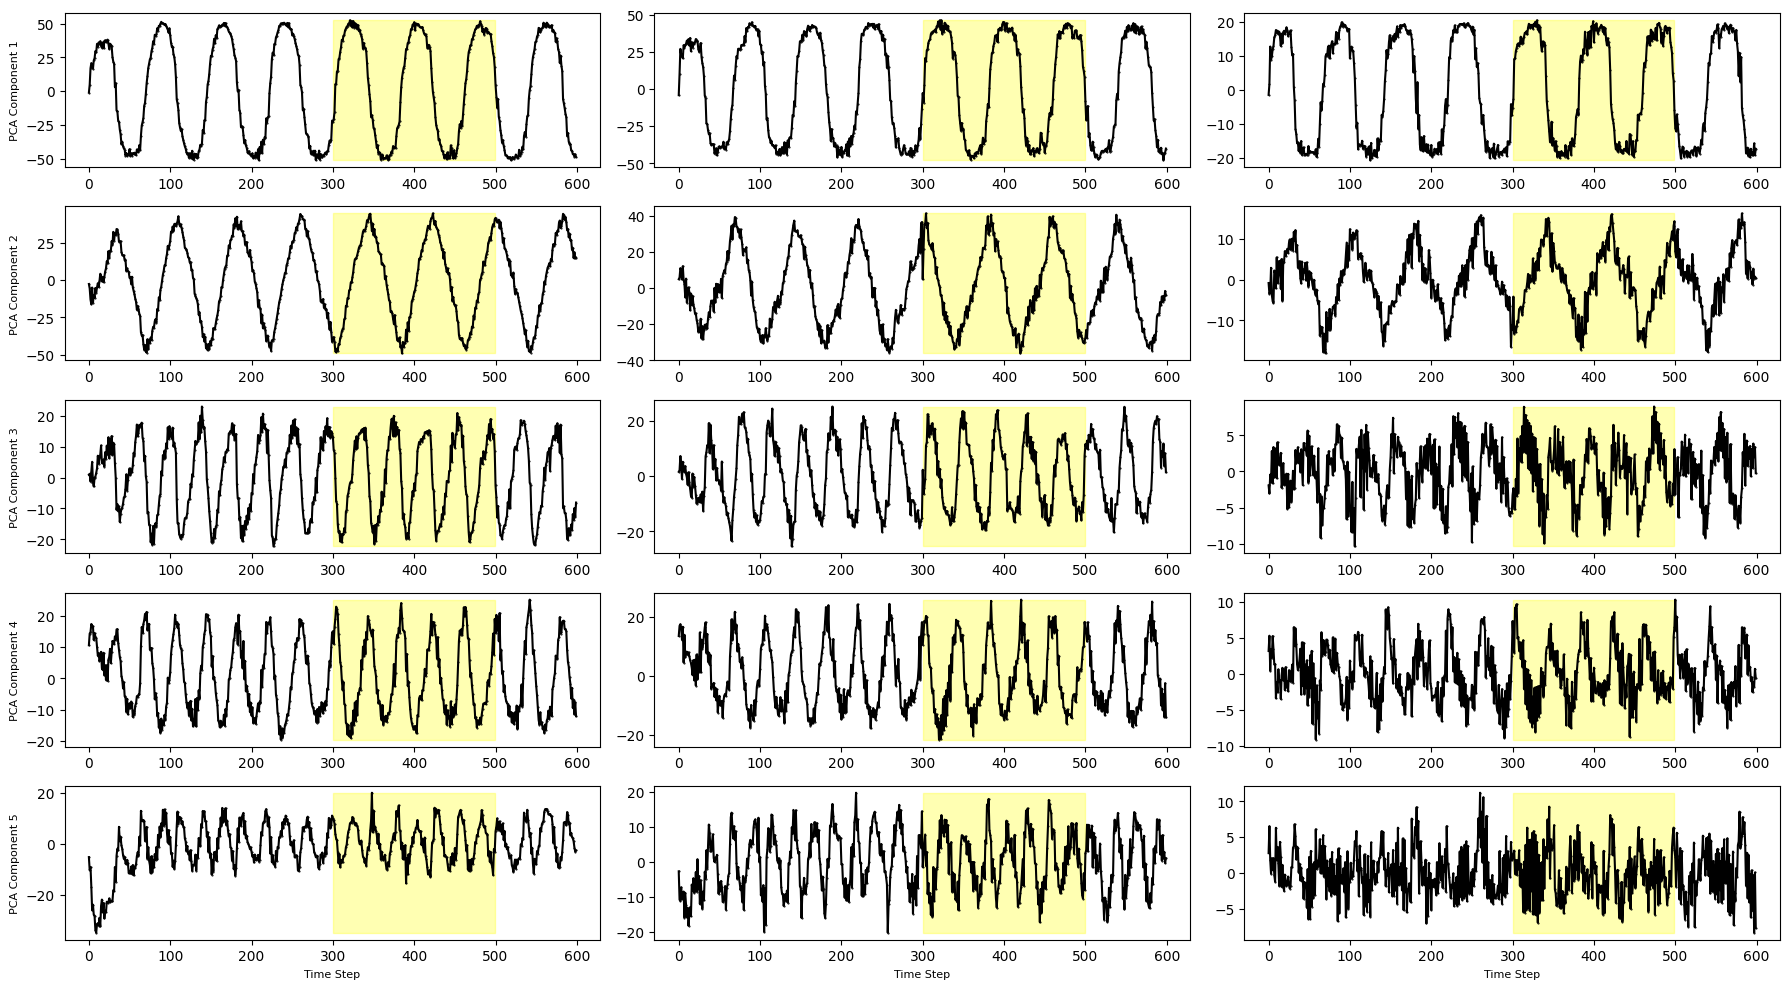

In [17]:
pca = PCA(n_components=5)
zero_hidden_weight = {}
zero_hidden_weight["layer1"] = zero["weight_hid_1"].reshape(zero["weight_hid_1"].shape[0] , -1)
zero_hidden_weight["layer2"] = zero["weight_hid_2"].reshape(zero["weight_hid_2"].shape[0] , -1)
zero_hidden_weight["layer3"] = zero["weight_hid_3"].reshape(zero["weight_hid_3"].shape[0] , -1)

zero_hidden_weight["PCA_layer1"] = pca.fit_transform(zero_hidden_weight["layer1"])
zero_hidden_weight["PCA_layer2"] = pca.fit_transform(zero_hidden_weight["layer2"])
zero_hidden_weight["PCA_layer3"] = pca.fit_transform(zero_hidden_weight["layer3"])

plot_list = [zero_hidden_weight["PCA_layer1"][0:600 , :] , zero_hidden_weight["PCA_layer2"][0:600 , :] ,zero_hidden_weight["PCA_layer3"][0:600 , :]]
PCA_plot_compare_single_component(plot_list , focus=[300,500], name="zero_hidden_weight_300-500")

Zero but Long

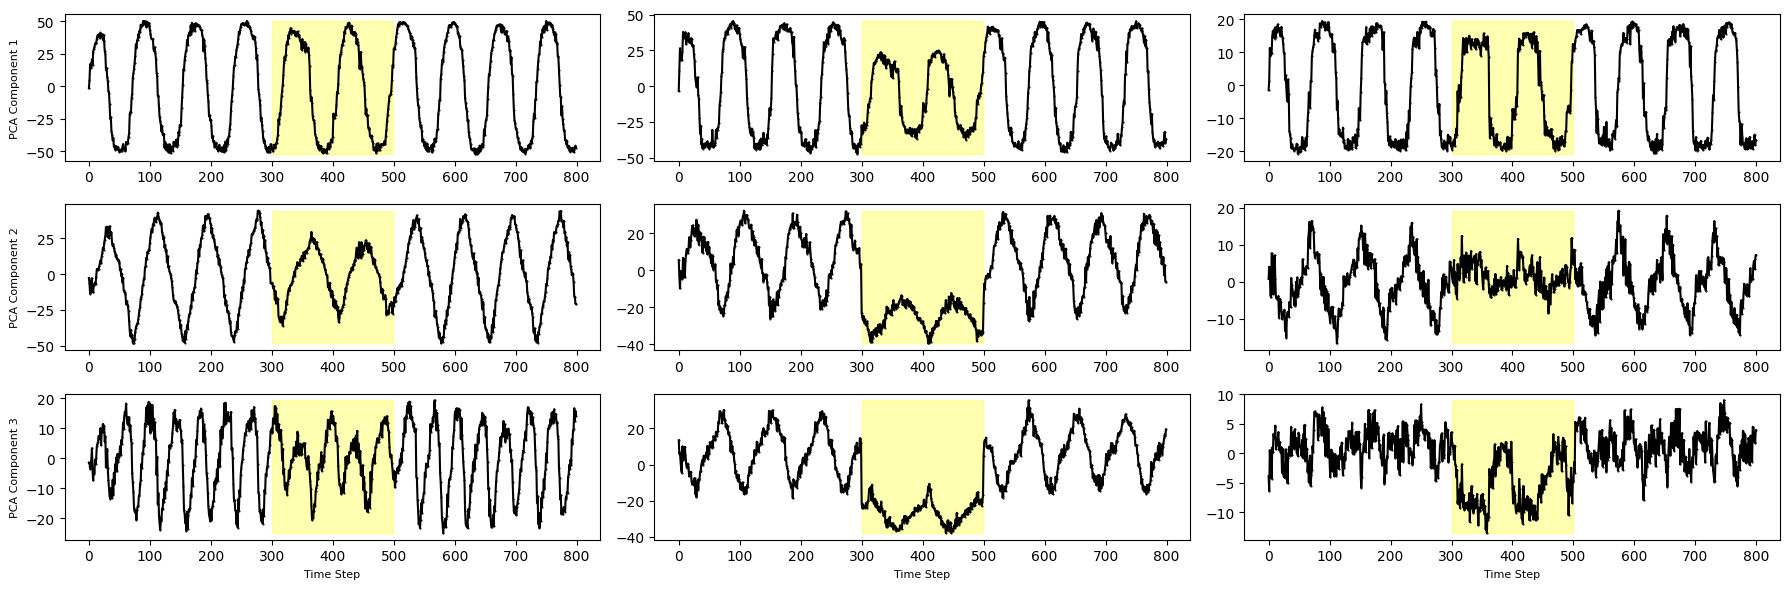

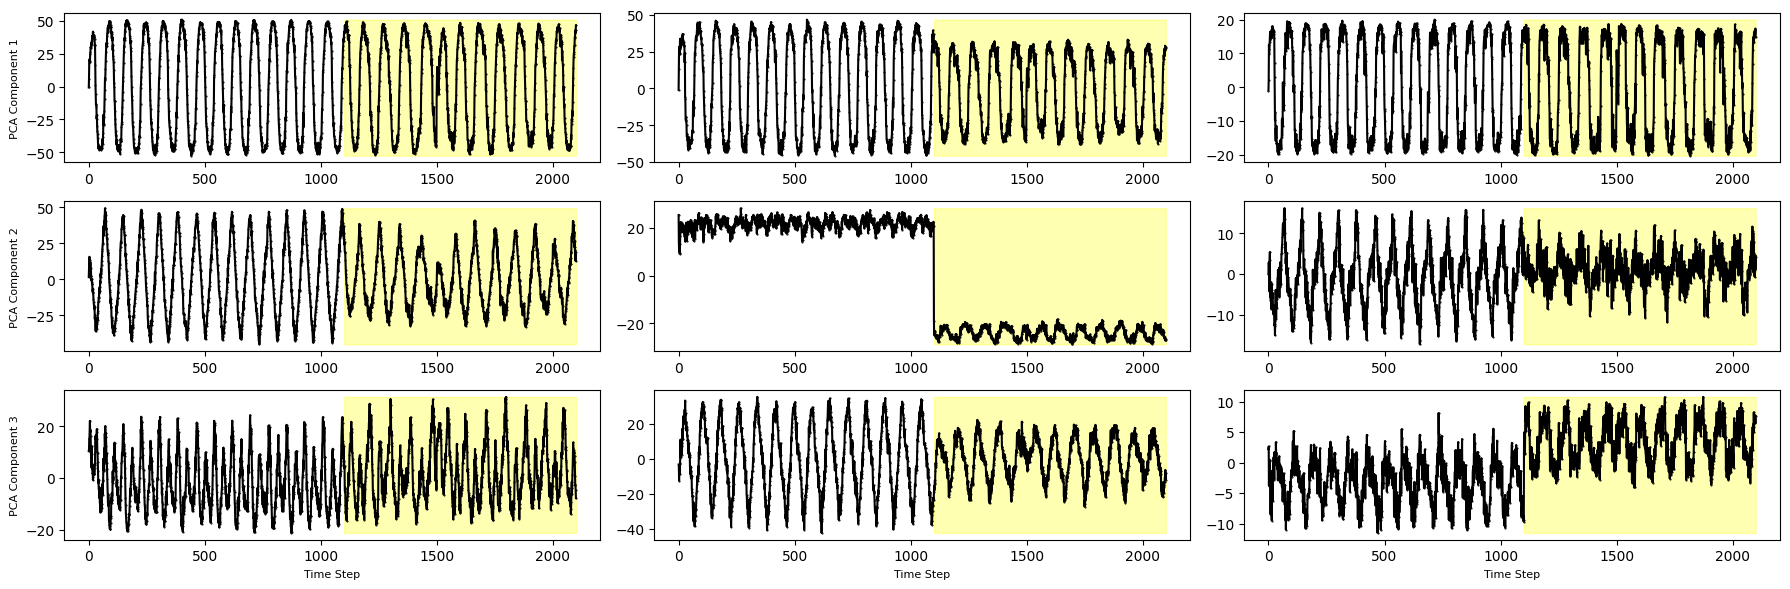

In [270]:
pca = PCA(n_components=3)
zero_long_hidden_weight = {}
zero_long_hidden_weight["layer1"] = zero_long["weight_hid_1"].reshape(zero_long["weight_hid_1"].shape[0] , -1)
zero_long_hidden_weight["layer2"] = zero_long["weight_hid_2"].reshape(zero_long["weight_hid_2"].shape[0] , -1)
zero_long_hidden_weight["layer3"] = zero_long["weight_hid_3"].reshape(zero_long["weight_hid_3"].shape[0] , -1)

zero_long_hidden_weight["PCA_layer1"] = pca.fit_transform(zero_long_hidden_weight["layer1"])
zero_long_hidden_weight["PCA_layer2"] = pca.fit_transform(zero_long_hidden_weight["layer2"])
zero_long_hidden_weight["PCA_layer3"] = pca.fit_transform(zero_long_hidden_weight["layer3"])

plot_list = [zero_long_hidden_weight["PCA_layer1"][0:800 , :] , zero_long_hidden_weight["PCA_layer2"][0:800 , :] ,zero_long_hidden_weight["PCA_layer3"][0:800 , :]]
PCA_plot_compare_single_component(plot_list , focus=[300,500])



zero_long2_hidden_weight = {}
zero_long2_hidden_weight["layer1"] = zero_long2["weight_hid_1"].reshape(zero_long2["weight_hid_1"].shape[0] , -1)
zero_long2_hidden_weight["layer2"] = zero_long2["weight_hid_2"].reshape(zero_long2["weight_hid_2"].shape[0] , -1)
zero_long2_hidden_weight["layer3"] = zero_long2["weight_hid_3"].reshape(zero_long2["weight_hid_3"].shape[0] , -1)

zero_long2_hidden_weight["PCA_layer1"] = pca.fit_transform(zero_long2_hidden_weight["layer1"])
zero_long2_hidden_weight["PCA_layer2"] = pca.fit_transform(zero_long2_hidden_weight["layer2"])
zero_long2_hidden_weight["PCA_layer3"] = pca.fit_transform(zero_long2_hidden_weight["layer3"])

plot_list = [zero_long2_hidden_weight["PCA_layer1"][: , :] , zero_long2_hidden_weight["PCA_layer2"][: , :] ,zero_long2_hidden_weight["PCA_layer3"][: , :]]
PCA_plot_compare_single_component(plot_list , focus=[1100,2100])

Normal thing

In [29]:
pca = PCA(n_components=3)
normal_hidden_weight = {}
normal_hidden_weight["layer1"] = normal["weight_hid_1"].reshape(normal["weight_hid_1"].shape[0] , -1)
normal_hidden_weight["layer2"] = normal["weight_hid_2"].reshape(normal["weight_hid_2"].shape[0] , -1)
normal_hidden_weight["layer3"] = normal["weight_hid_3"].reshape(normal["weight_hid_3"].shape[0] , -1)

normal_hidden_weight["PCA_layer1"] = pca.fit_transform(normal_hidden_weight["layer1"])
normal_hidden_weight["PCA_layer2"] = pca.fit_transform(normal_hidden_weight["layer2"])
normal_hidden_weight["PCA_layer3"] = pca.fit_transform(normal_hidden_weight["layer3"])

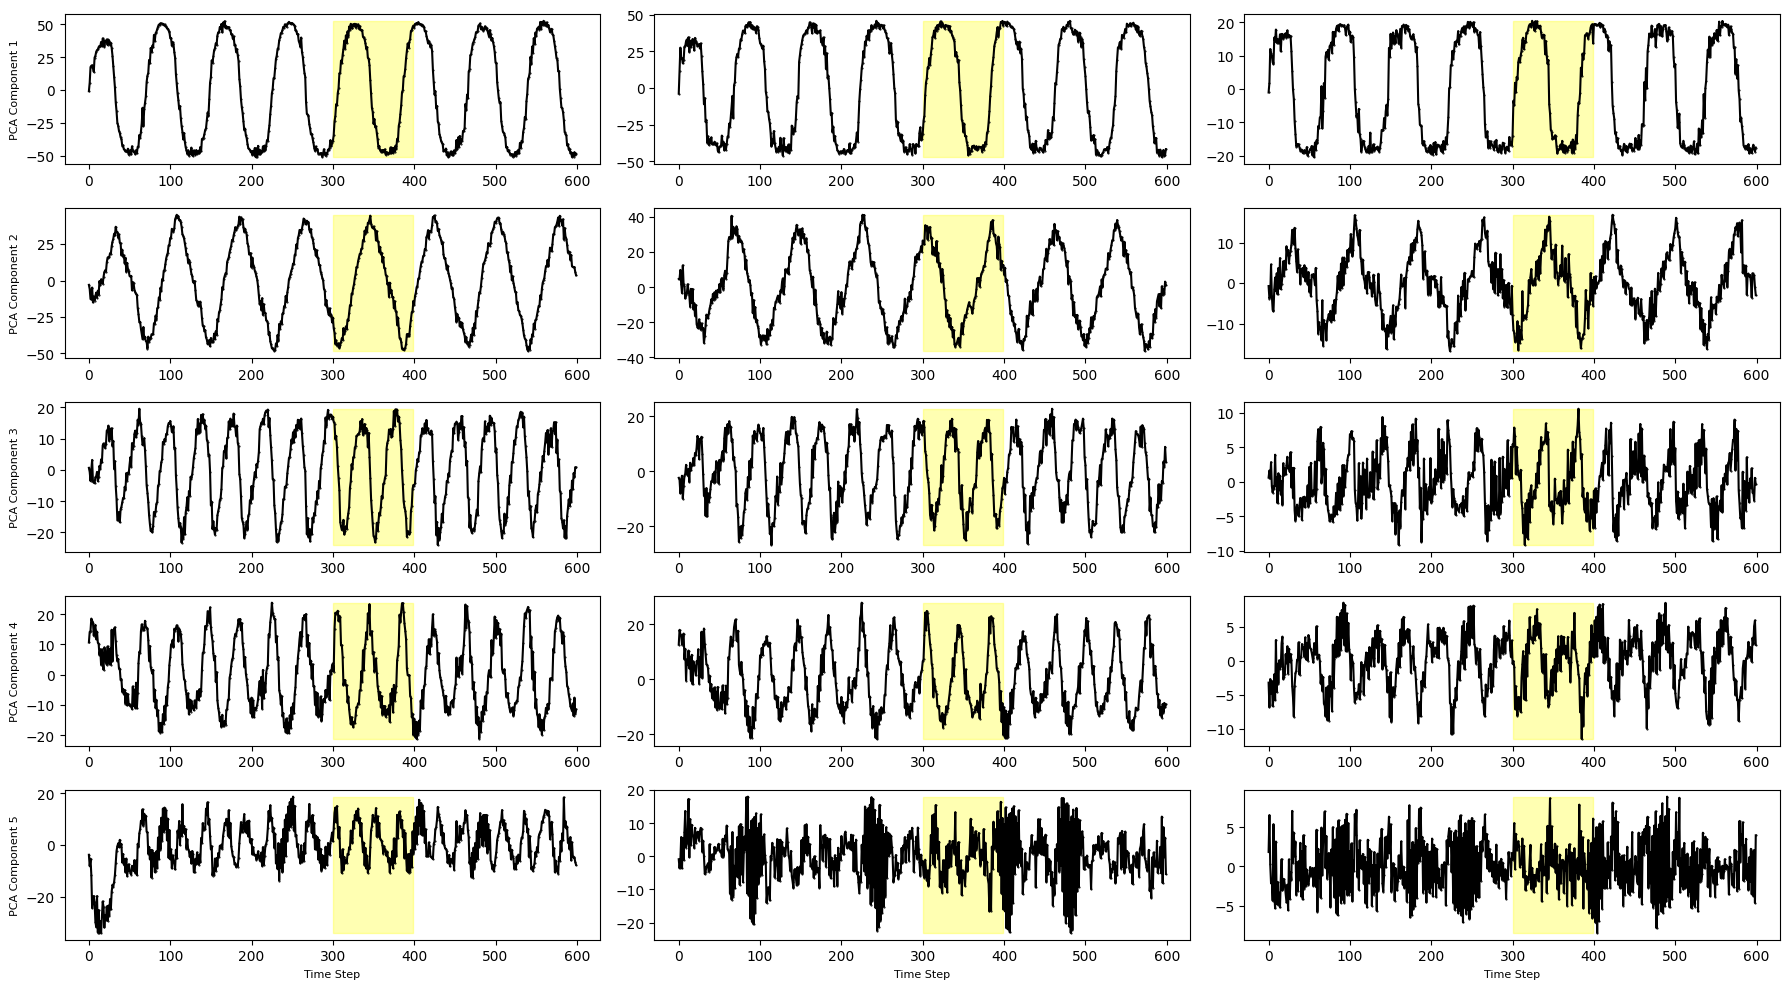

In [22]:
plot_list = [normal_hidden_weight["PCA_layer1"][0:600 , :] , normal_hidden_weight["PCA_layer2"][0:600 , :] ,normal_hidden_weight["PCA_layer3"][0:600 , :]]
PCA_plot_compare_single_component(plot_list , focus=[300,400])

Compare - No dif :(

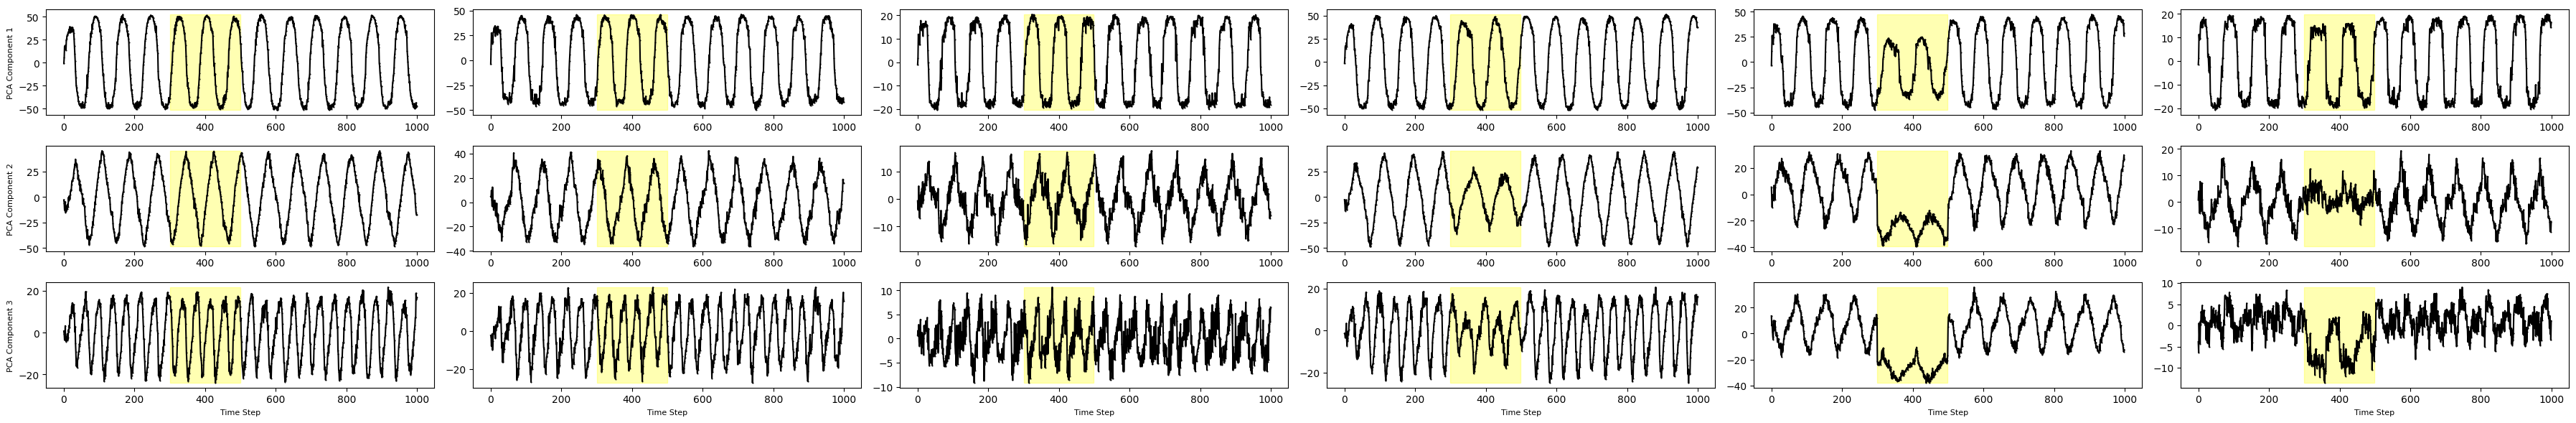

In [31]:
plot_list = [normal_hidden_weight["PCA_layer1"][0:1000 , :] , normal_hidden_weight["PCA_layer2"][0:1000 , :] ,normal_hidden_weight["PCA_layer3"][0:1000 , :]] + [zero_long_hidden_weight["PCA_layer1"][0:1000 , :] , zero_long_hidden_weight["PCA_layer2"][0:1000 , :] ,zero_long_hidden_weight["PCA_layer3"][0:1000 , :]]
PCA_plot_compare_single_component(plot_list , focus=[300,500])

### Sensory Group

In [229]:
pos_idx = np.arange(0,19)
vel_idx = np.arange(19,19*2)
action_idx = np.arange(19*2,19*3)
IMU_idx = np.arange(57,60)
fc_idx = np.arange(60,64)

In [427]:
zero_long["weight_hid_1"].shape

(1000, 64, 128)

In [431]:
pca_pos = pca.fit_transform(zero_long["weight_hid_1"][:,pos_idx,:].reshape(zero_long["weight_hid_1"].shape[0] , -1))
pca_vel = pca.fit_transform(zero_long["weight_hid_1"][:,vel_idx,:].reshape(zero_long["weight_hid_1"].shape[0] , -1))
pca_action = pca.fit_transform(zero_long["weight_hid_1"][:,action_idx,:].reshape(zero_long["weight_hid_1"].shape[0] , -1))
pca_IMU = pca.fit_transform(zero_long["weight_hid_1"][:,IMU_idx,:].reshape(zero_long["weight_hid_1"].shape[0] , -1))
pca_fc = pca.fit_transform(zero_long["weight_hid_1"][:,fc_idx,:].reshape(zero_long["weight_hid_1"].shape[0] , -1))

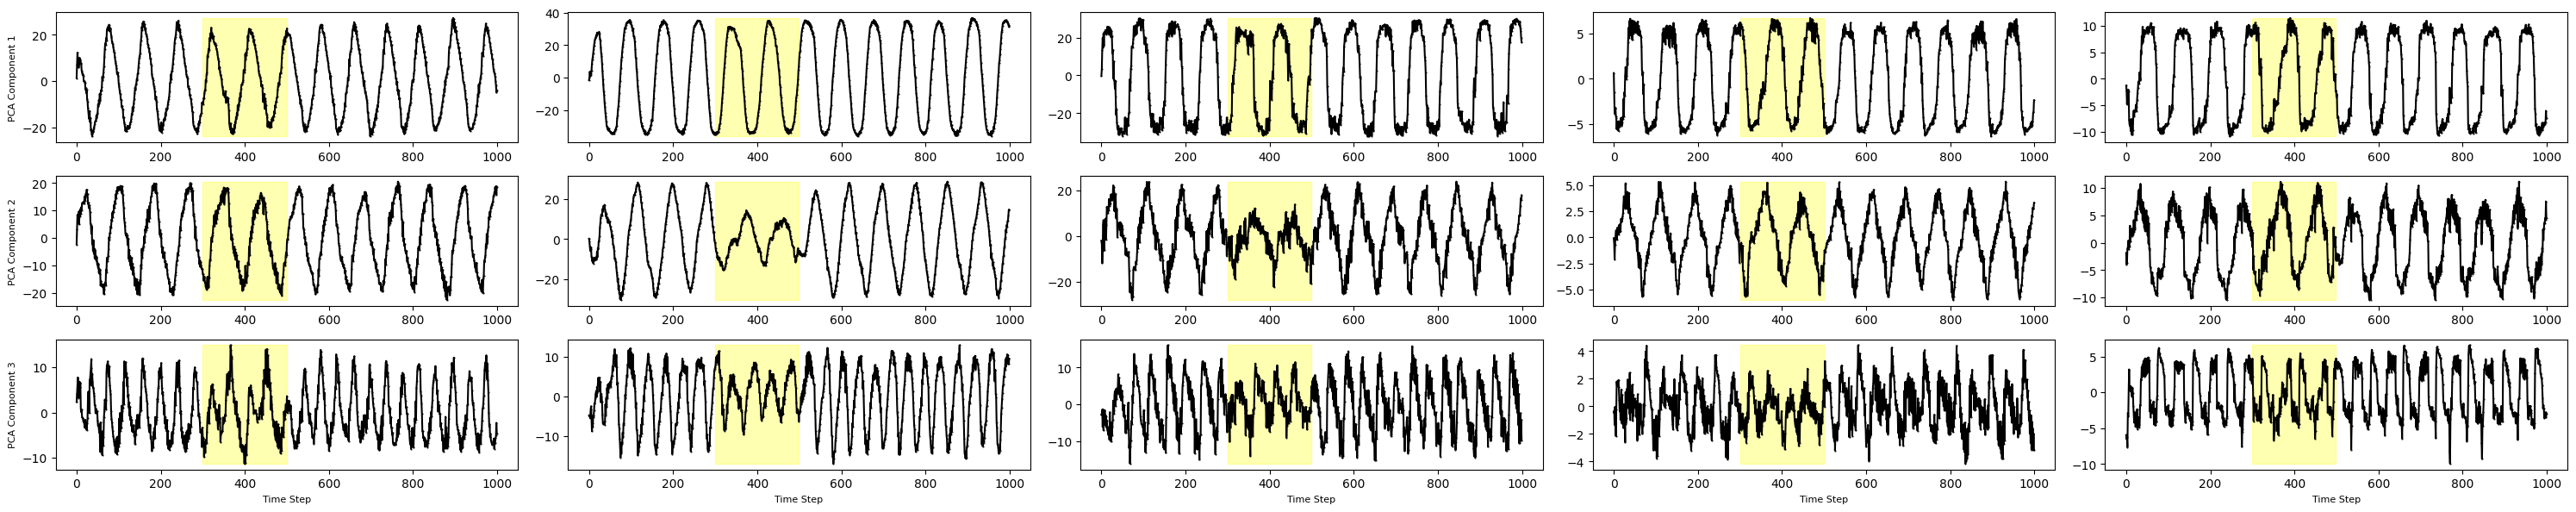

In [432]:
PCA_plot_compare_single_component([pca_pos , pca_vel , pca_action , pca_IMU , pca_fc] , focus=[300,500])

## Important Joint

In [18]:
zero_long["input"].shape
num_joint = 19
joint_idx = []
for i in range(num_joint):
    temp = [i , num_joint + i , 2*num_joint +i]
    joint_idx.append(temp)
joint_idx = np.array(joint_idx)

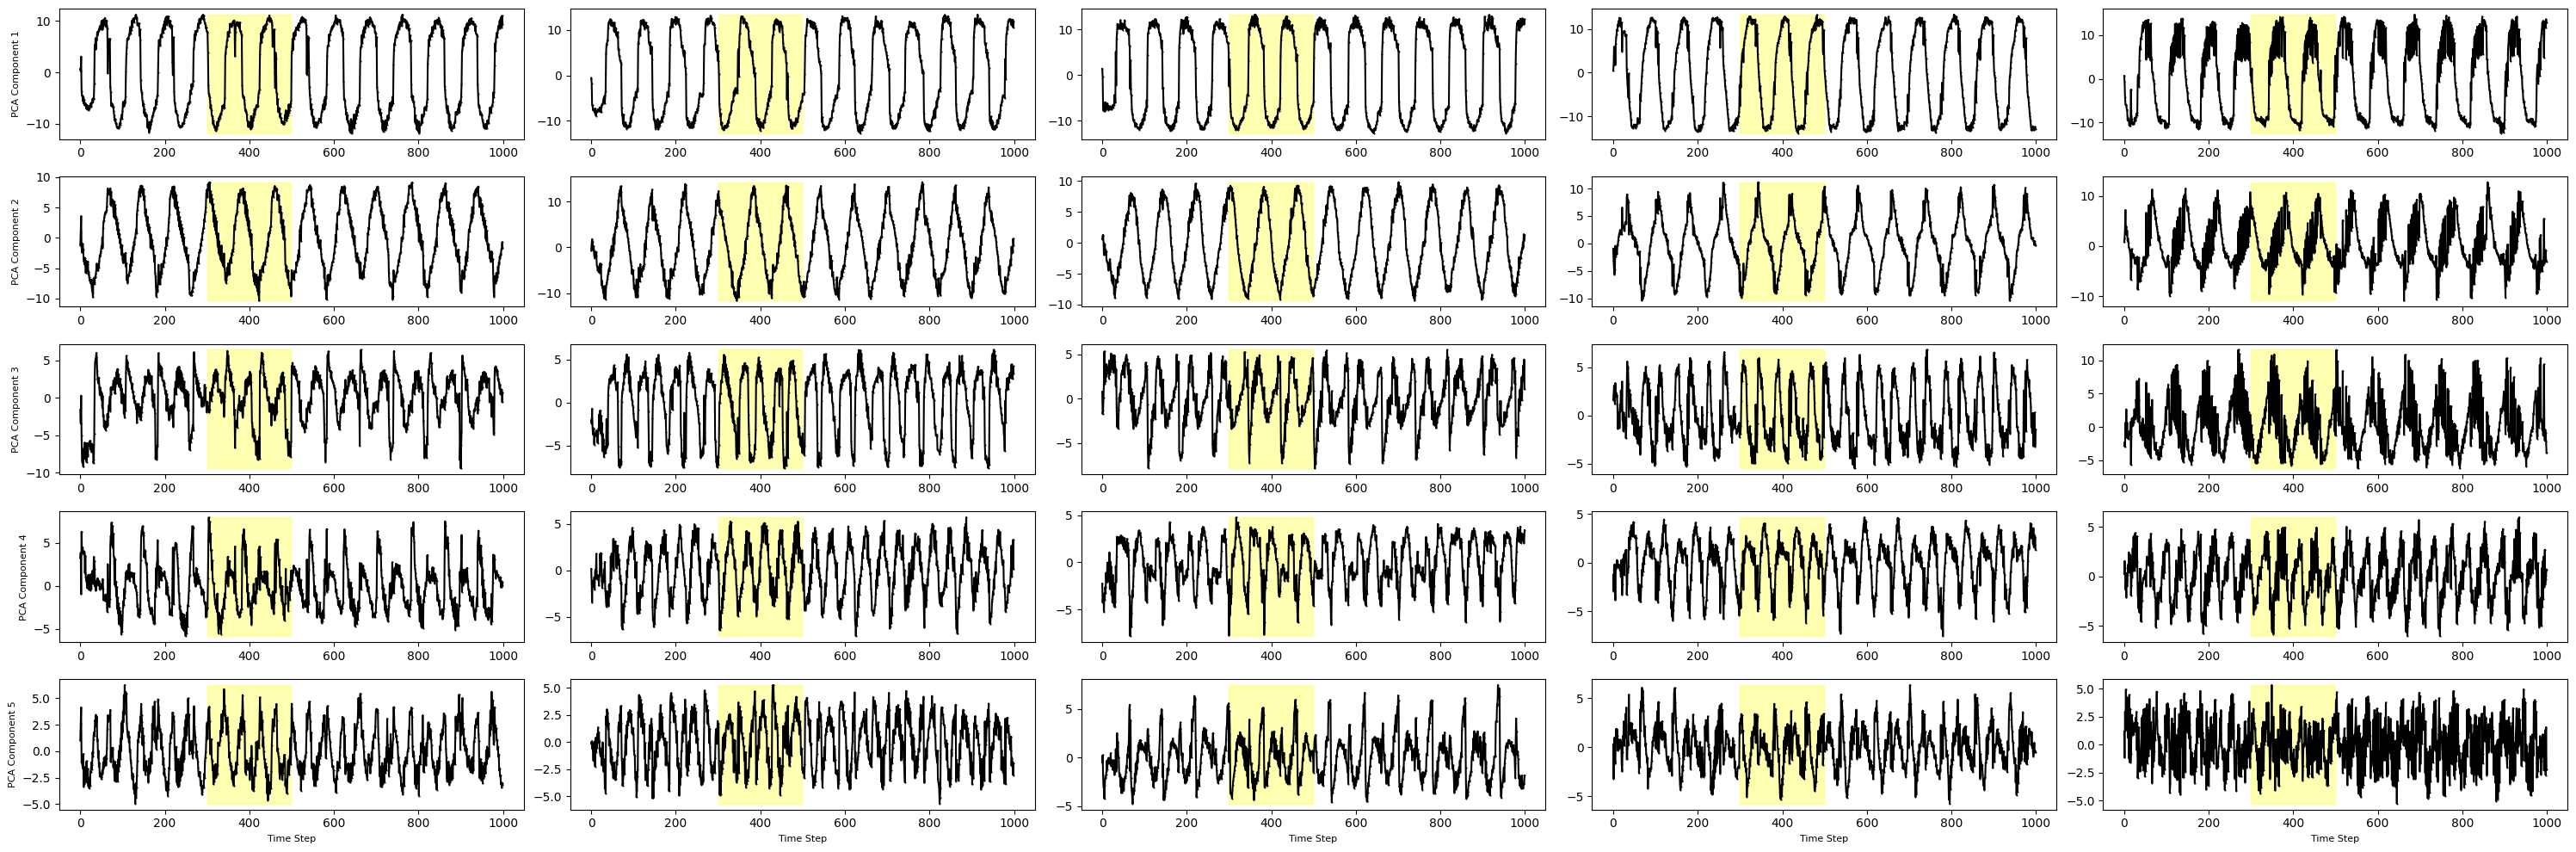

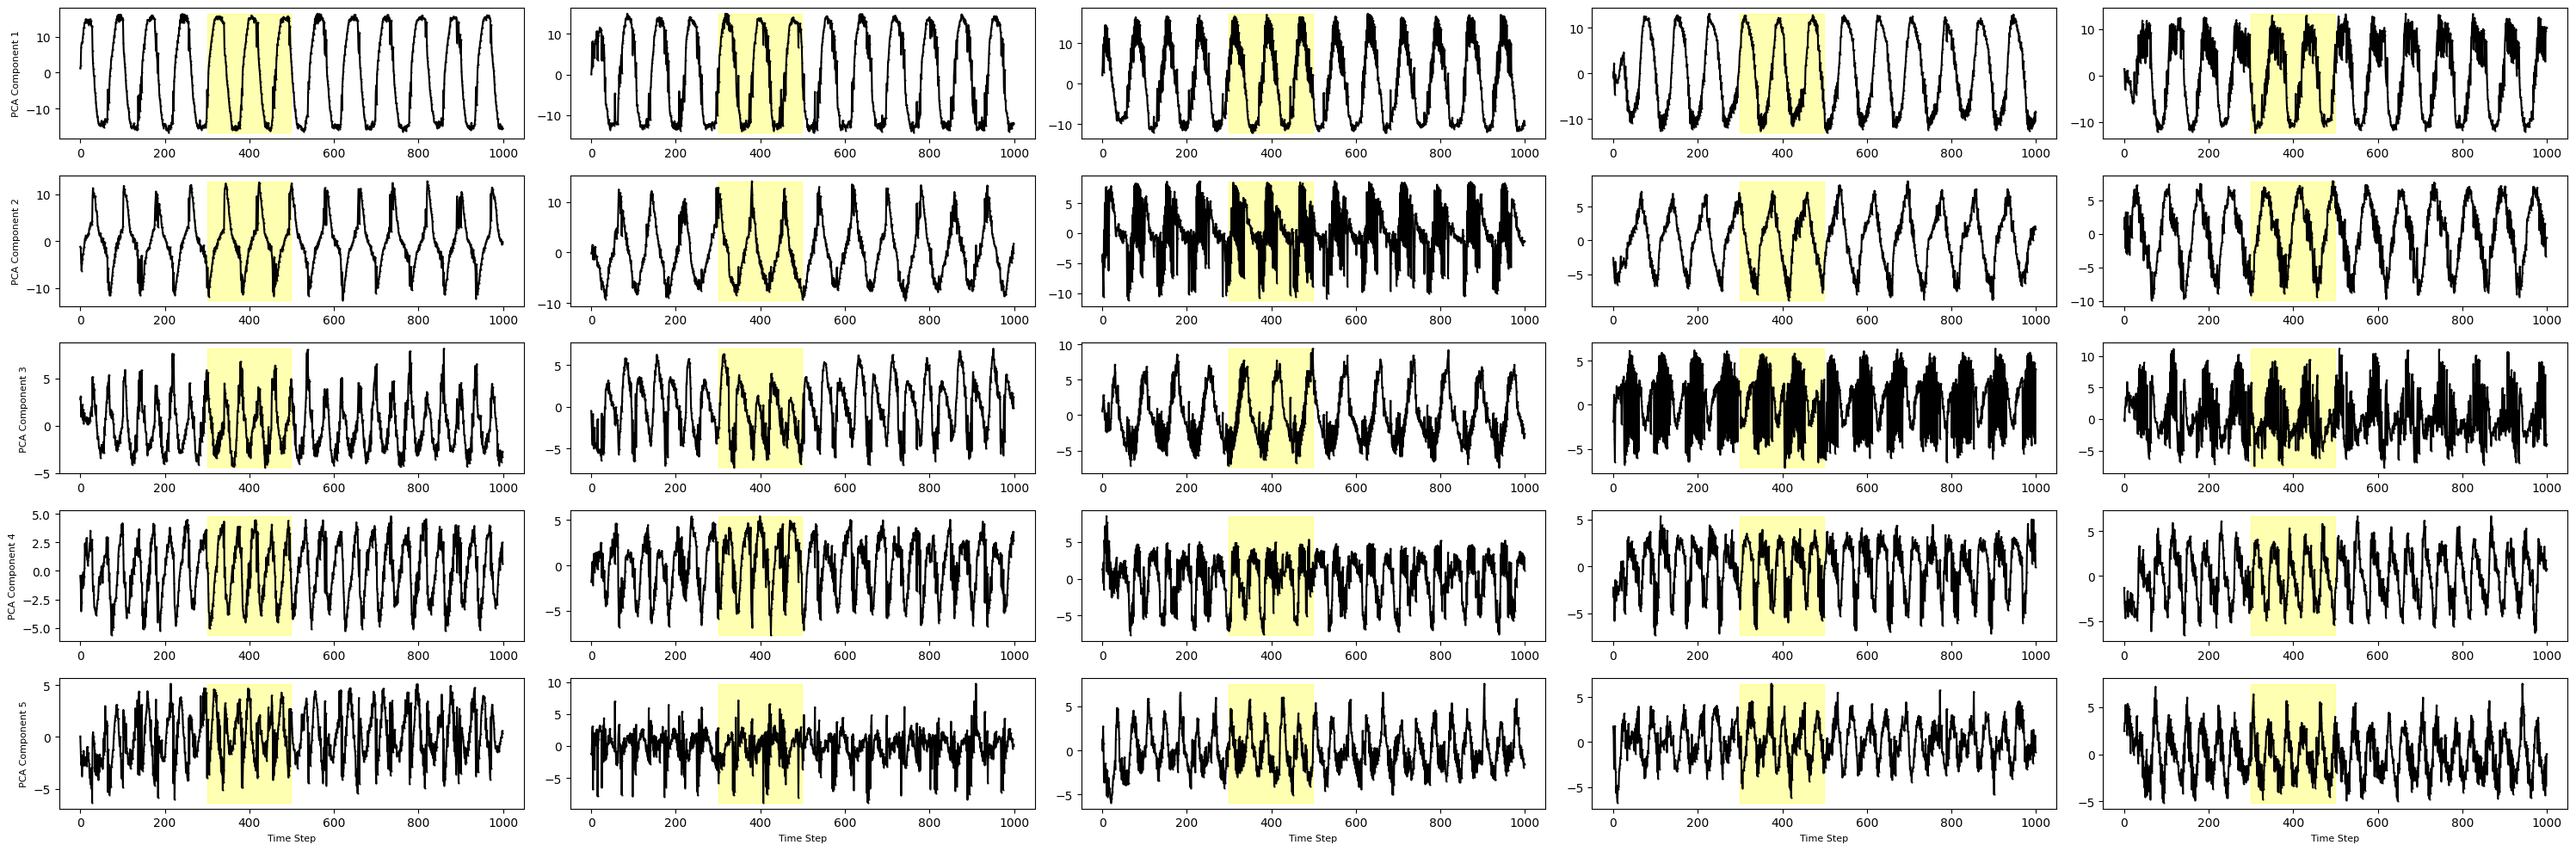

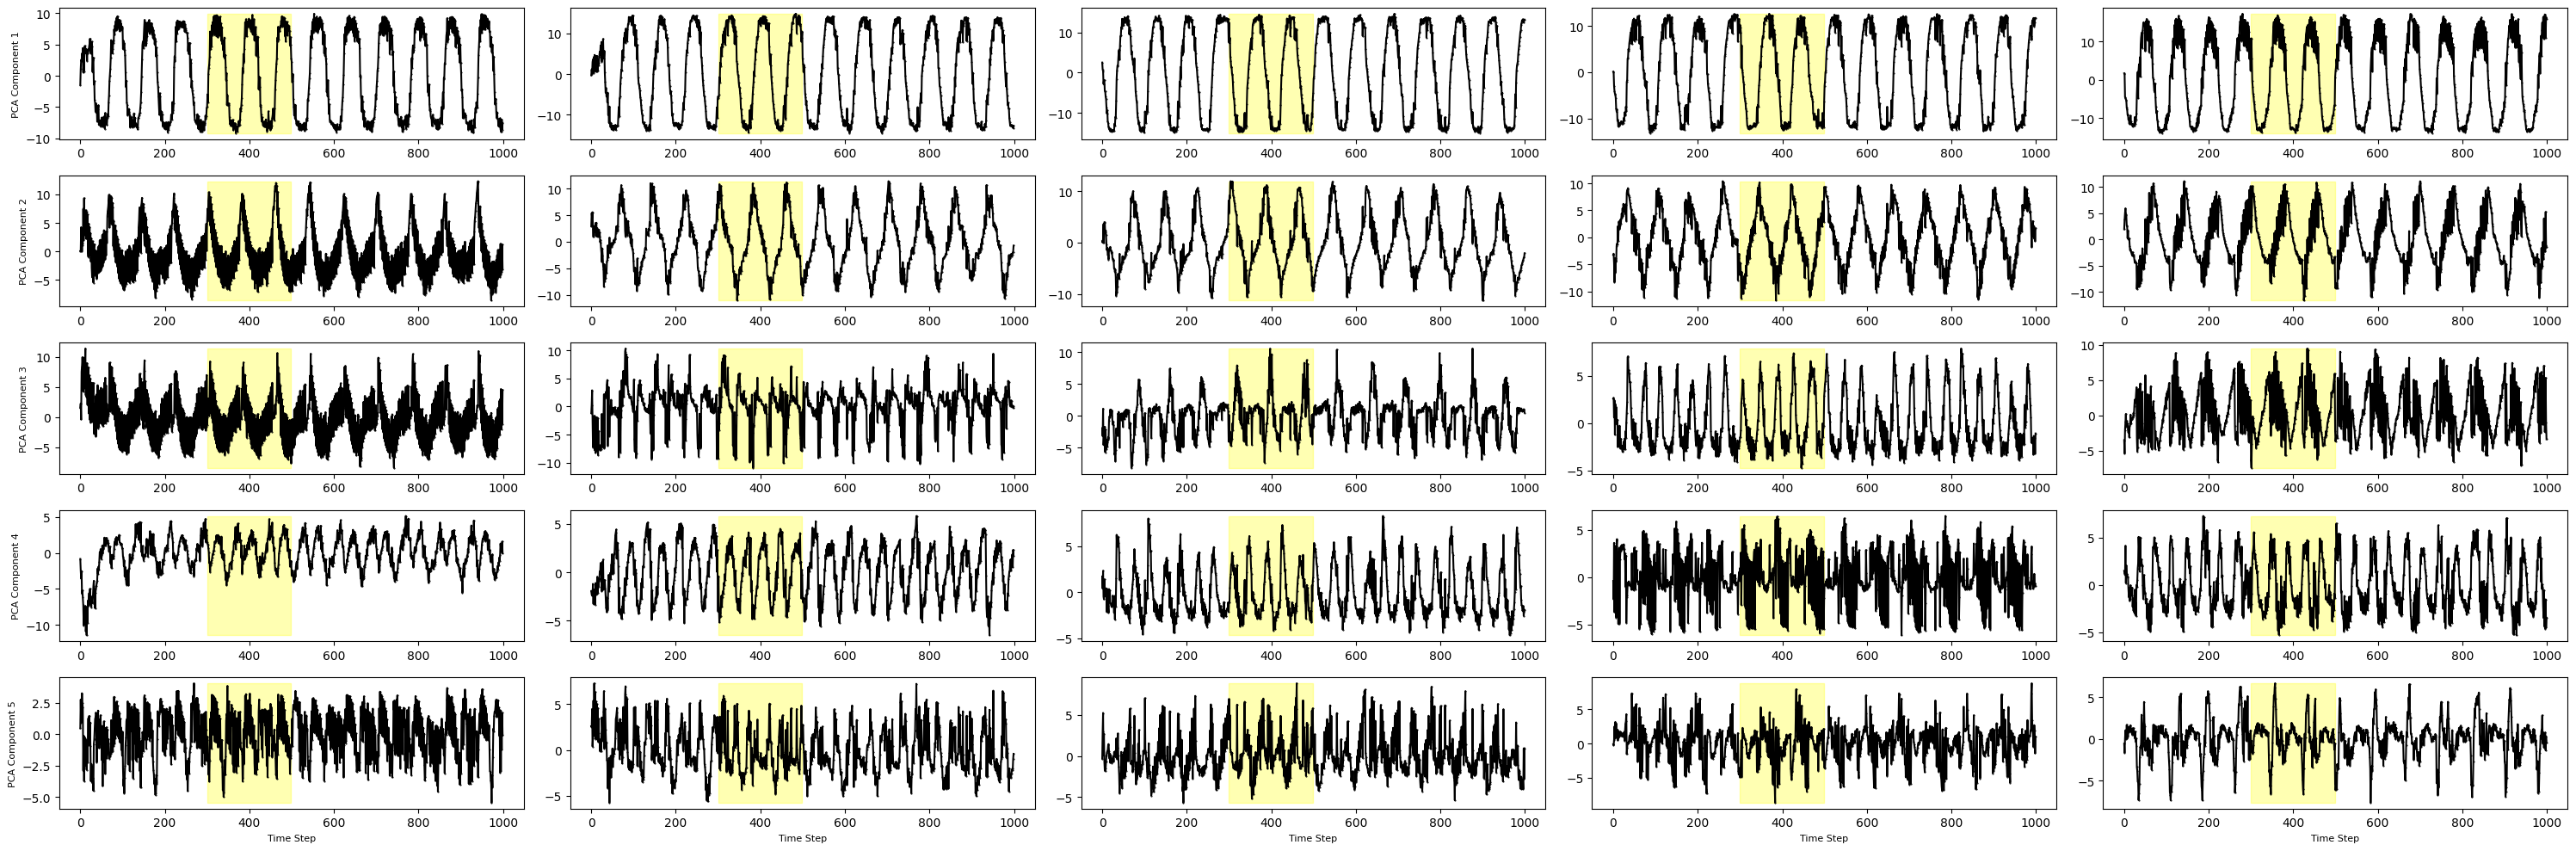

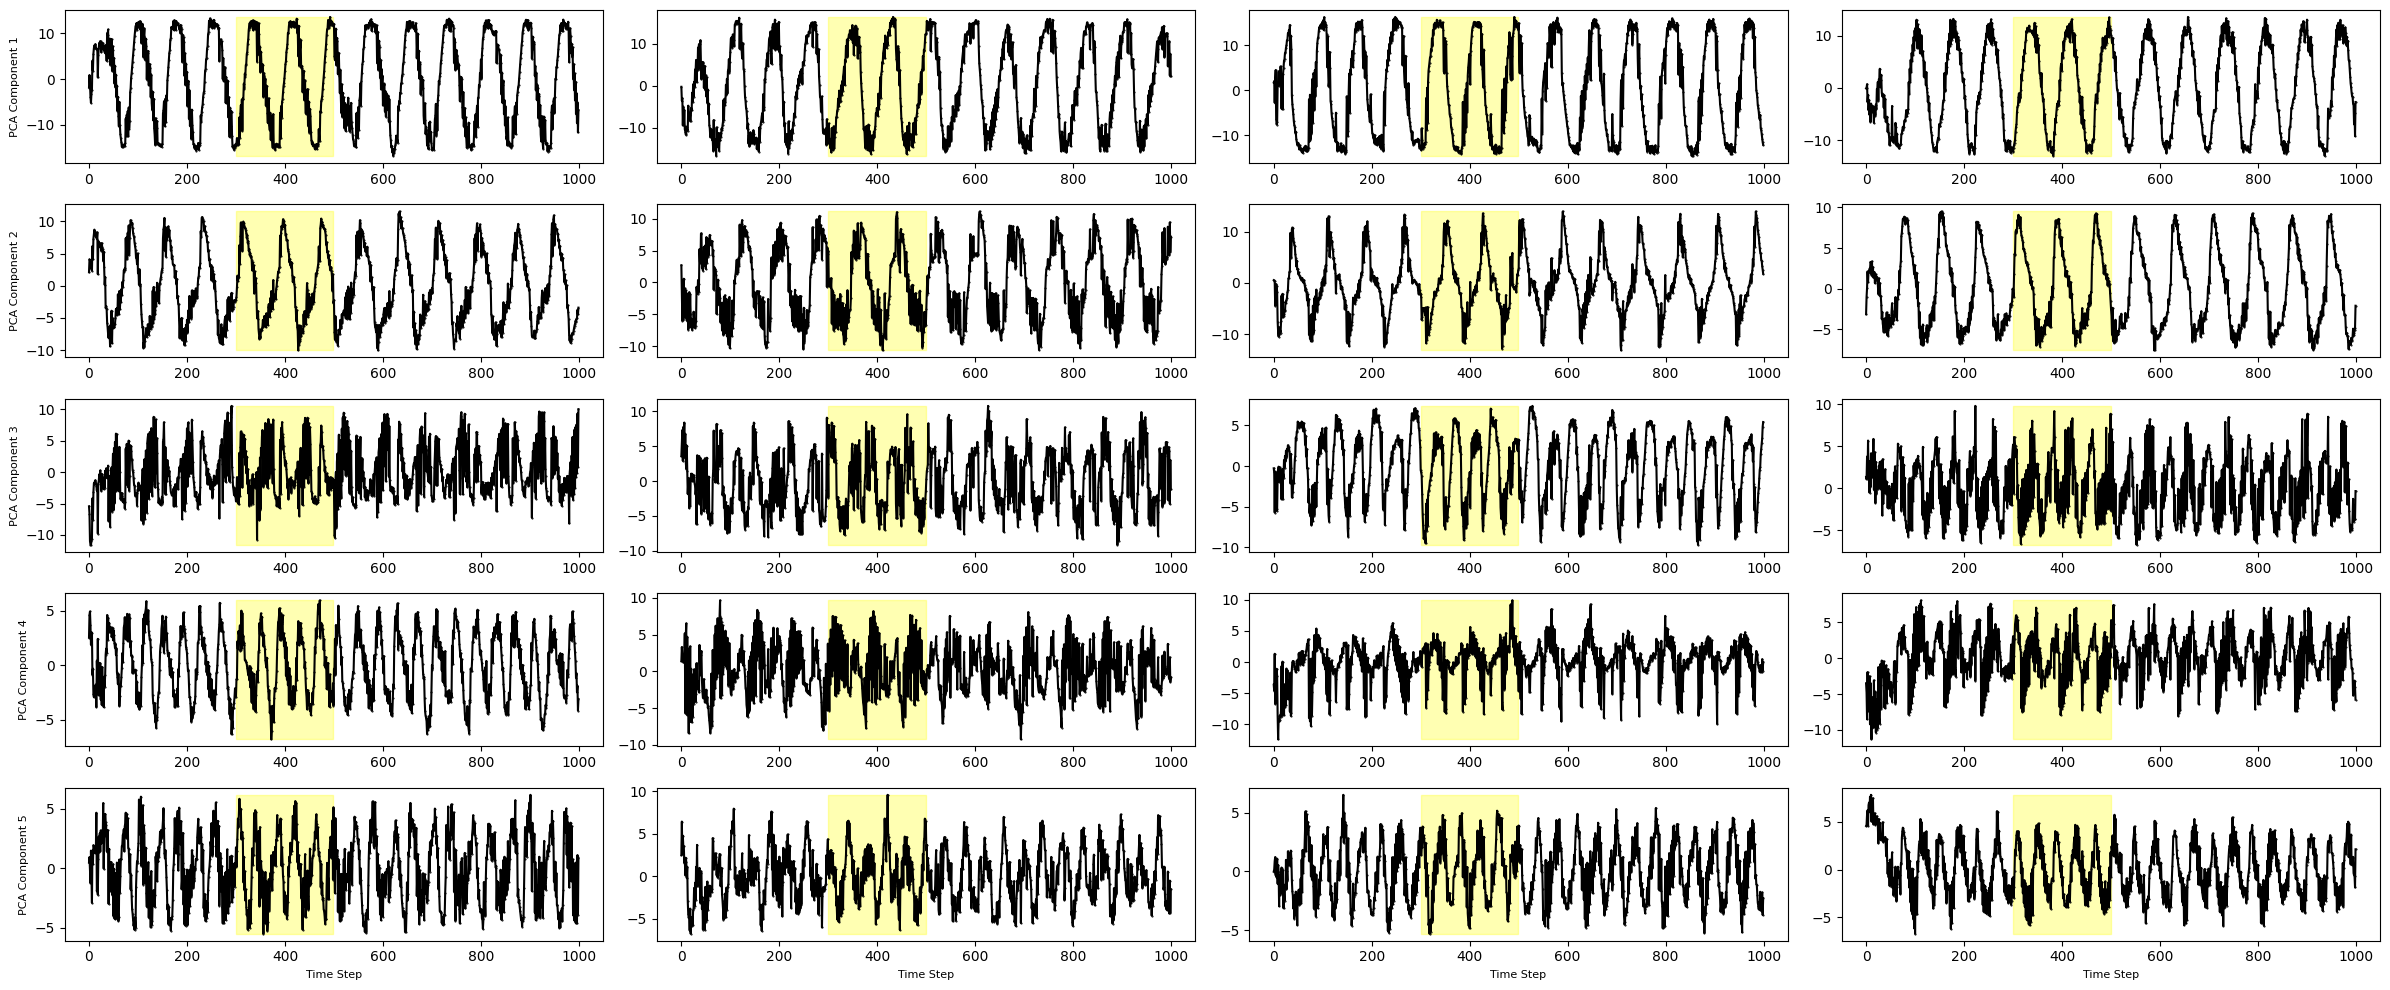

In [19]:
joint_set = []
for i in range(len(joint_idx)):
    j = pca.fit_transform(zero["weight_hid_1"][:,joint_idx[i],:].reshape(zero["weight_hid_1"].shape[0] , -1))
    joint_set.append(j)
PCA_plot_compare_single_component(joint_set[:5] , focus=[300,500] , name="compare1_5")
PCA_plot_compare_single_component(joint_set[5:10] , focus=[300,500] , name="compare2_5")
PCA_plot_compare_single_component(joint_set[10:15] , focus=[300,500] , name="compare3_5")
PCA_plot_compare_single_component(joint_set[15:20] , focus=[300,500] , name="compare4_4")

## Estimate MI

In [141]:
import numpy as np
from scipy.spatial.distance import cdist
from scipy.special import psi

def ksg_estimator(X, Y, k):
    N = len(X)
    
    # Combine X and Y into a joint dataset Z
    Z = np.column_stack((X, Y))
    
    # Calculate pairwise distances in the joint space and in the marginal spaces
    dist_Z = cdist(Z, Z, metric='euclidean')
    dist_X = cdist(X, X, metric='euclidean')
    dist_Y = cdist(Y, Y, metric='euclidean')

    # Sort the distances and find the k-th nearest neighbor distances
    dist_Z_sorted = np.sort(dist_Z, axis=1)
    dist_X_sorted = np.sort(dist_X, axis=1)
    dist_Y_sorted = np.sort(dist_Y, axis=1)
    # Get the k-th neighbor distances for joint and marginal spaces
    eps_Z = dist_Z_sorted[:, k]
    eps_X = dist_X_sorted[:, k]
    eps_Y = dist_Y_sorted[:, k]
    eps_max = np.maximum(eps_X, eps_Y)
    
    # Count the number of neighbors within the k-th neighbor distance for X and Y
    nx = np.array([np.sum(dist_X[i] <= eps_max[i]) for i in range(N)])
    ny = np.array([np.sum(dist_Y[i] <= eps_max[i]) for i in range(N)])
    
    # Compute the digamma functions and the final MI estimate
    digamma_k = psi(k)
    digamma_N = psi(N)
    
    # Average over all data points
    avg_digamma_nx_ny = np.mean(psi(nx + 1) + psi(ny + 1))
    
    # MI estimate
    MI = digamma_k - avg_digamma_nx_ny + digamma_N
    return MI

# Example usage with random data
# X = np.random.rand(1000,3)
# Y = np.random.rand(1000,3)
# k = 5  # Number of neighbors

# mi = ksg_estimator(X, Y, k)
# print(f"Estimated MI: {mi}")

Reminder param

In [ ]:
print(f"Joint INDEX : {joint_idx}") # param for group of joint(pos  vel  action)

### Normal Case

In [271]:
pca = PCA(n_components=3)
start_idx = 100
end_idx = 1100
normal_mi = np.zeros((19,2))  # First index: layer 2,3 ,second index : joint index
normal_pca = []
normal_pca_hid2 = pca.fit_transform(zero_long2["weight_hid_2"][start_idx:end_idx,:,:].reshape(zero_long2["weight_hid_2"][start_idx:end_idx,:,:].shape[0] , -1))
normal_pca_hid3 = pca.fit_transform(zero_long2["weight_hid_3"][start_idx:end_idx,:,:].reshape(zero_long2["weight_hid_3"][start_idx:end_idx,:,:].shape[0] , -1))


for i,joint in enumerate(joint_idx):
    temp = pca.fit_transform(zero_long2["weight_hid_1"][start_idx:end_idx,joint,:].reshape(zero_long2["weight_hid_1"][start_idx:end_idx,joint,:].shape[0] , -1))
    normal_pca.append(temp)
    del temp
normal_pca = np.array(normal_pca)

for index , joint in enumerate(joint_idx):
    normal_mi[index,0] = ksg_estimator(normal_pca[index] , normal_pca_hid2 , 5)
    normal_mi[index,1] = ksg_estimator(normal_pca[index] , normal_pca_hid3 , 5)

### Abnormal Case

In [272]:
abnormal_mi = np.zeros((19,2))  # First index: layer 2,3 ,second index : joint index
start_idx = 1100
end_idx = 2100
abnormal_pca = []
abnormal_pca_hid2 = pca.fit_transform(zero_long2["weight_hid_2"][start_idx:end_idx,:,:].reshape(zero_long2["weight_hid_2"][start_idx:end_idx,:,:].shape[0] , -1))
abnormal_pca_hid3 = pca.fit_transform(zero_long2["weight_hid_3"][start_idx:end_idx,:,:].reshape(zero_long2["weight_hid_3"][start_idx:end_idx,:,:].shape[0] , -1))


for i,joint in enumerate(joint_idx):
    temp = pca.fit_transform(zero_long2["weight_hid_1"][start_idx:end_idx,joint,:].reshape(zero_long2["weight_hid_1"][start_idx:end_idx,joint,:].shape[0] , -1))
    abnormal_pca.append(temp)
    del temp
abnormal_pca = np.array(abnormal_pca)

for index , joint in enumerate(joint_idx):
    abnormal_mi[index,0] = ksg_estimator(abnormal_pca[index] , abnormal_pca_hid2 , 5)
    abnormal_mi[index,1] = ksg_estimator(abnormal_pca[index] , abnormal_pca_hid3 , 5)

In [201]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="" ,cbar=True, **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current Axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    if cbar:
        cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
        cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(range(data.shape[1]), labels=col_labels,
                  rotation=45, ha="right", rotation_mode="anchor")
    ax.set_yticks(range(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    # ax.tick_params(top=True, bottom=False,
    #                labeltop=True, labelbottom=False)

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

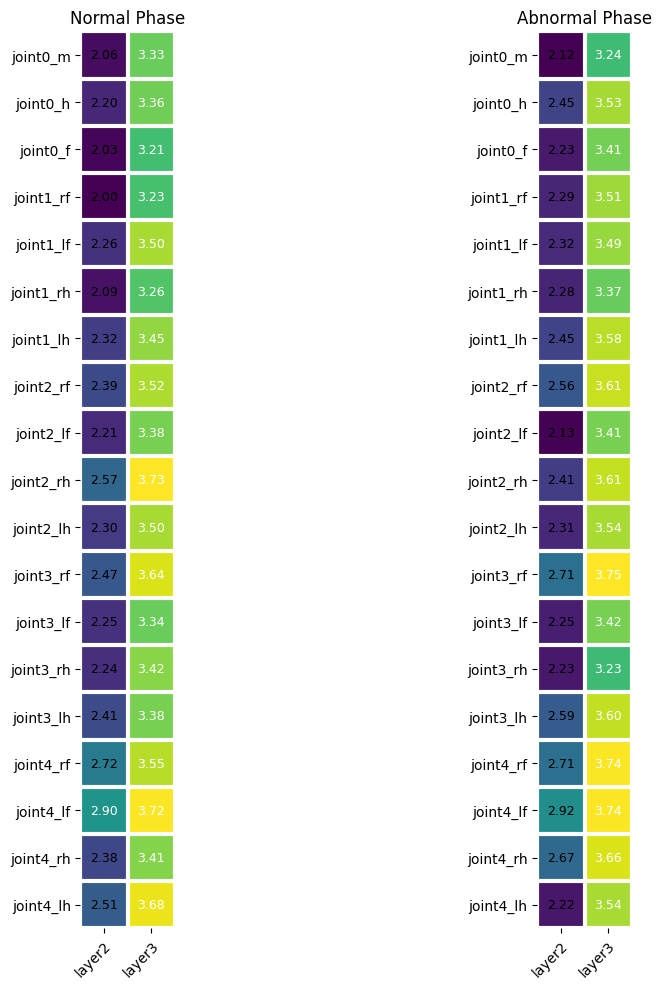

In [282]:
fig, ((ax), (ax2)) = plt.subplots(1, 2, figsize=(12, 10))
label = ['joint0_m', 'joint0_h', 'joint0_f', 'joint1_rf', 'joint1_lf', 'joint1_rh', 'joint1_lh', 'joint2_rf', 'joint2_lf', 'joint2_rh', 'joint2_lh', 'joint3_rf', 'joint3_lf', 'joint3_rh', 'joint3_lh', 'joint4_rf', 'joint4_lf', 'joint4_rh', 'joint4_lh']
ax.title.set_text('Normal Phase')
im, cbar = heatmap(normal_mi, row_labels=label, col_labels=['layer2', 'layer3'] , ax=ax , cbar=False)
annotate_heatmap(im, valfmt="{x:.2f}" ,size=9)

ax2.title.set_text('Abnormal Phase')
im2, cbar2 = heatmap(abnormal_mi, row_labels=label, col_labels=['layer2', 'layer3'] , ax=ax2 , cbar=False)
annotate_heatmap(im2, valfmt="{x:.2f}" , size=9)
fig.tight_layout()

### Cross Measuring

#### Input normal -> Layer Abnormal

In [274]:
cross0_mi = np.zeros((19,2))  # First index: layer 2,3 ,second index : joint index
cross0_pca = []
start_idx = 1100
end_idx = 2100

# Abnormal
cross0_pca_hid2 = pca.fit_transform(zero_long2["weight_hid_2"][start_idx:end_idx,:,:].reshape(zero_long2["weight_hid_2"][start_idx:end_idx,:,:].shape[0] , -1))
cross0_pca_hid3 = pca.fit_transform(zero_long2["weight_hid_3"][start_idx:end_idx,:,:].reshape(zero_long2["weight_hid_3"][start_idx:end_idx,:,:].shape[0] , -1))


start_idx = 100
end_idx = 1100

# Normal
for i,joint in enumerate(joint_idx):
    temp = pca.fit_transform(zero_long2["weight_hid_1"][start_idx:end_idx,joint,:].reshape(zero_long2["weight_hid_1"][start_idx:end_idx,joint,:].shape[0] , -1))
    cross0_pca.append(temp)
    del temp
cross0_pca = np.array(cross0_pca)

for index , joint in enumerate(joint_idx):
    cross0_mi[index,0] = ksg_estimator(cross0_pca[index] , cross0_pca_hid2 , 5)
    cross0_mi[index,1] = ksg_estimator(cross0_pca[index] , cross0_pca_hid3 , 5)

#### Input abnormal -> Layer normal

In [275]:
cross1_mi = np.zeros((19,2))  # First index: layer 2,3 ,second index : joint index
cross1_pca = []

start_idx = 100
end_idx = 1100

# Normal
cross1_pca_hid2 = pca.fit_transform(zero_long2["weight_hid_2"][start_idx:end_idx,:,:].reshape(zero_long2["weight_hid_2"][start_idx:end_idx,:,:].shape[0] , -1))
cross1_pca_hid3 = pca.fit_transform(zero_long2["weight_hid_3"][start_idx:end_idx,:,:].reshape(zero_long2["weight_hid_3"][start_idx:end_idx,:,:].shape[0] , -1))

start_idx = 1100
end_idx = 2100

# Abnormal
for i,joint in enumerate(joint_idx):
    temp = pca.fit_transform(zero_long2["weight_hid_1"][start_idx:end_idx,joint,:].reshape(zero_long2["weight_hid_1"][start_idx:end_idx,joint,:].shape[0] , -1))
    cross1_pca.append(temp)
    del temp
cross1_pca = np.array(cross0_pca)

for index , joint in enumerate(joint_idx):
    cross1_mi[index,0] = ksg_estimator(cross1_pca[index] , cross1_pca_hid2 , 5)
    cross1_mi[index,1] = ksg_estimator(cross1_pca[index] , cross1_pca_hid3 , 5)

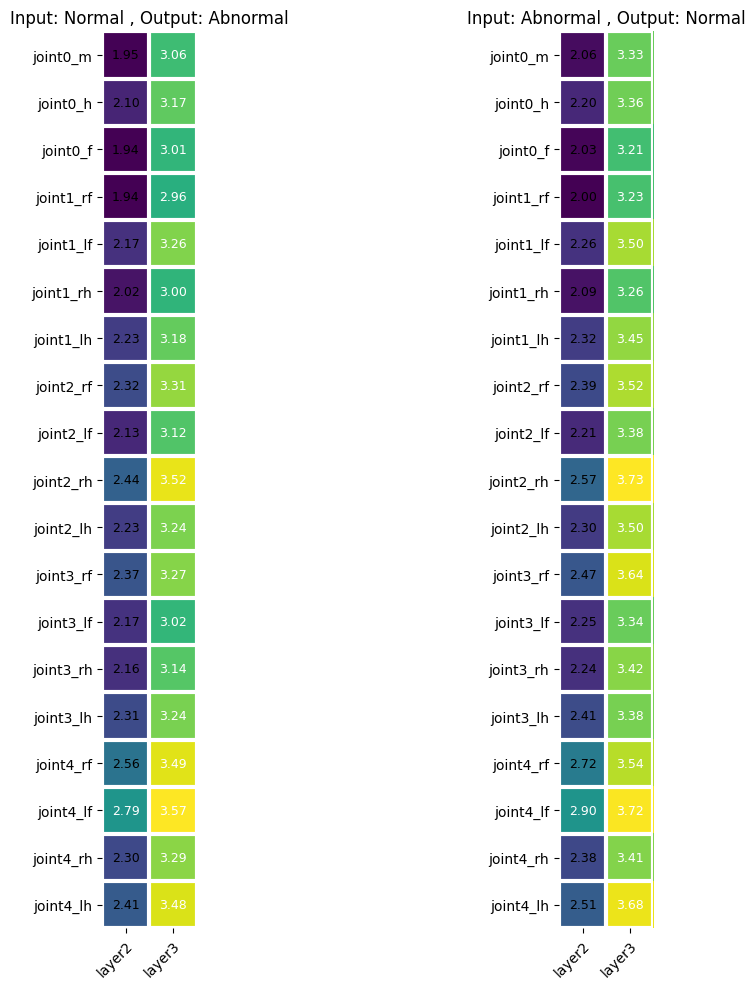

In [283]:
label = ['joint0_m', 'joint0_h', 'joint0_f', 'joint1_rf', 'joint1_lf', 'joint1_rh', 'joint1_lh', 'joint2_rf', 'joint2_lf', 'joint2_rh', 'joint2_lh', 'joint3_rf', 'joint3_lf', 'joint3_rh', 'joint3_lh', 'joint4_rf', 'joint4_lf', 'joint4_rh', 'joint4_lh']

fig, ((ax), (ax2)) = plt.subplots(1, 2, figsize=(12, 10))
ax.title.set_text('Input: Normal , Output: Abnormal')
im, cbar = heatmap(cross0_mi, row_labels=label, col_labels=['layer2', 'layer3'] , ax=ax , cbar=False)
annotate_heatmap(im, valfmt="{x:.2f}" ,size=9)

ax2.title.set_text('Input: Abnormal , Output: Normal')
im2, cbar2 = heatmap(cross1_mi, row_labels=label, col_labels=['layer2', 'layer3'] , ax=ax2 , cbar=False)
annotate_heatmap(im2, valfmt="{x:.2f}" , size=9)
fig.tight_layout()

## Estimating Group

### Normal Case

In [286]:
# PCA input sensory
start_idx = 100
end_idx = 500
pca1_pos = pca.fit_transform(zero_long2["weight_hid_1"][start_idx:end_idx,pos_idx,:].reshape(zero_long2["weight_hid_1"][start_idx:end_idx,pos_idx,:].shape[0] , -1))
pca1_vel = pca.fit_transform(zero_long2["weight_hid_1"][start_idx:end_idx,vel_idx,:].reshape(zero_long2["weight_hid_1"][start_idx:end_idx,pos_idx,:].shape[0] , -1))
pca1_action = pca.fit_transform(zero_long2["weight_hid_1"][start_idx:end_idx,action_idx,:].reshape(zero_long2["weight_hid_1"][start_idx:end_idx,pos_idx,:].shape[0] , -1))
pca1_IMU = pca.fit_transform(zero_long2["weight_hid_1"][start_idx:end_idx,IMU_idx,:].reshape(zero_long2["weight_hid_1"][start_idx:end_idx,pos_idx,:].shape[0] , -1))
pca1_fc = pca.fit_transform(zero_long2["weight_hid_1"][start_idx:end_idx,fc_idx,:].reshape(zero_long2["weight_hid_1"][start_idx:end_idx,pos_idx,:].shape[0] , -1))

# PCA hidden layer
normal_pca_hid2 = pca.fit_transform(zero_long2["weight_hid_2"][start_idx:end_idx,:,:].reshape(zero_long2["weight_hid_2"][start_idx:end_idx,:,:].shape[0] , -1))
normal_pca_hid3 = pca.fit_transform(zero_long2["weight_hid_3"][start_idx:end_idx,:,:].reshape(zero_long2["weight_hid_3"][start_idx:end_idx,:,:].shape[0] , -1))

# Estiamte MI
sensory1_mi = np.zeros((5,2))  # First index: layer 2,3 ,second index : joint index
sensory_pca = [pca1_pos , pca1_vel , pca1_action , pca1_IMU , pca1_fc]
for index , sensory in enumerate(sensory_pca):
    sensory1_mi[index,0] = ksg_estimator(sensory , normal_pca_hid2 , 5)
    sensory1_mi[index,1] = ksg_estimator(sensory , normal_pca_hid3 , 5)

### Abnormal Case

In [287]:
# PCA input sensory
start_idx = 600
end_idx = 1000

pca2_pos = pca.fit_transform(zero_long2["weight_hid_1"][start_idx:end_idx,pos_idx,:].reshape(zero_long2["weight_hid_1"][start_idx:end_idx,pos_idx,:].shape[0] , -1))
pca2_vel = pca.fit_transform(zero_long2["weight_hid_1"][start_idx:end_idx,vel_idx,:].reshape(zero_long2["weight_hid_1"][start_idx:end_idx,pos_idx,:].shape[0] , -1))
pca2_action = pca.fit_transform(zero_long2["weight_hid_1"][start_idx:end_idx,action_idx,:].reshape(zero_long2["weight_hid_1"][start_idx:end_idx,pos_idx,:].shape[0] , -1))
pca2_IMU = pca.fit_transform(zero_long2["weight_hid_1"][start_idx:end_idx,IMU_idx,:].reshape(zero_long2["weight_hid_1"][start_idx:end_idx,pos_idx,:].shape[0] , -1))
pca2_fc = pca.fit_transform(zero_long2["weight_hid_1"][start_idx:end_idx,fc_idx,:].reshape(zero_long2["weight_hid_1"][start_idx:end_idx,pos_idx,:].shape[0] , -1))

# PCA hidden layer
abnormal_pca_hid2 = pca.fit_transform(zero_long2["weight_hid_2"][start_idx:end_idx,:,:].reshape(zero_long2["weight_hid_2"][start_idx:end_idx,:,:].shape[0] , -1))
abnormal_pca_hid3 = pca.fit_transform(zero_long2["weight_hid_3"][start_idx:end_idx,:,:].reshape(zero_long2["weight_hid_3"][start_idx:end_idx,:,:].shape[0] , -1))

# Estiamte MI
sensory2_mi = np.zeros((5,2))  # First index: layer 2,3 ,second index : joint index
sensory_pca = [pca2_pos , pca2_vel , pca2_action , pca2_IMU , pca2_fc]
for index , sensory in enumerate(sensory_pca):
    sensory2_mi[index,0] = ksg_estimator(sensory , abnormal_pca_hid2 , 5)
    sensory2_mi[index,1] = ksg_estimator(sensory , abnormal_pca_hid3 , 5)

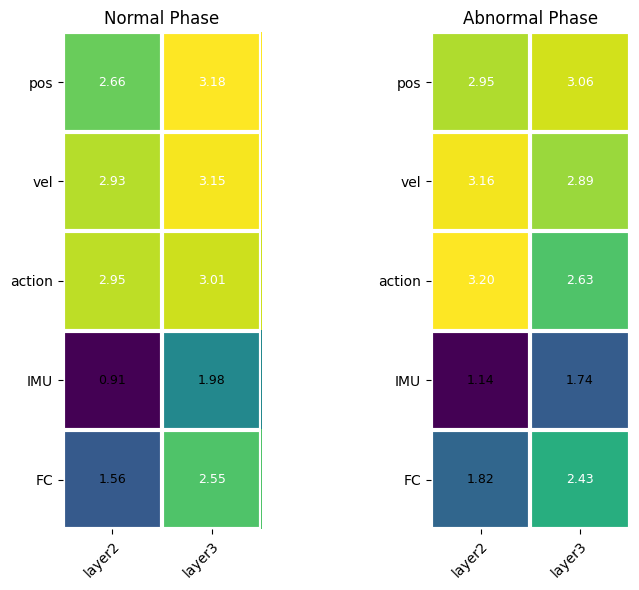

In [ ]:
fig, ((ax), (ax2)) = plt.subplots(1, 2, figsize=(8, 6))
ax.title.set_text('Normal Phase')
im, cbar = heatmap(sensory1_mi, row_labels=["pos" , "vel" , "action" , "IMU" , "FC"], col_labels=['layer2', 'layer3'] , ax=ax , cbar=False)
annotate_heatmap(im, valfmt="{x:.2f}" ,size=9)

ax2.title.set_text('Abnormal Phase')
im2, cbar2 = heatmap(sensory2_mi, row_labels=["pos" , "vel" , "action" , "IMU" , "FC"], col_labels=['layer2', 'layer3'] , ax=ax2 , cbar=False)
annotate_heatmap(im2, valfmt="{x:.2f}" , size=9)
fig.tight_layout()

In [ ]:
fig, ((ax), (ax2)) = plt.subplots(1, 2, figsize=(12, 10))
ax.title.set_text('Input: Normal , Output: Abnormal')
im, cbar = heatmap(cross0_mi, row_labels=[f'joint_{i}' for i in range(19)], col_labels=['layer2', 'layer3'] , ax=ax , cbar=False)
annotate_heatmap(im, valfmt="{x:.2f}" ,size=9)

ax2.title.set_text('Input: Abnormal , Output: Normal')
im2, cbar2 = heatmap(cross1_mi, row_labels=[f'joint_{i}' for i in range(19)], col_labels=['layer2', 'layer3'] , ax=ax2 , cbar=False)
annotate_heatmap(im2, valfmt="{x:.2f}" , size=9)
fig.tight_layout()